# Atlas Processing - Initial Image Creation

- Documentation: https://nilearn.github.io/auto_examples/01_plotting/plot_surf_atlas.html
- Note: nilearn's 'surface.load_surface_data' function does not suppport .mgh / .mgz files; must use mri_convert or mris_convert (part of Freesurfer) to first convert to an acceptable format, e.g. .nii

In [75]:
import nilearn
from nilearn import surface
from nilearn import plotting

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image, ImageOps
import pickle
import collections

In [76]:
from nilearn import datasets

destrieux_atlas = datasets.fetch_atlas_surf_destrieux()
destrieux_dict = dict(enumerate([str(l)[2:-1] for l in destrieux_atlas.labels]))

## 0. Set up directories

In [4]:
# === DIRECTORIES === #

# input data directories
# overall format:
# -- hbn_dir/sub-{EID}/label_subdir/parc_filename

hbn_dir = '/oak/stanford/groups/jyeatman/HBN/BIDS_curated/derivatives/freesurfer'
label_subdir = '/label'
surf_subdir = '/surf'

curv_filename = 'lh.curv'
infl_filename = 'lh.inflated'
pial_filename = 'lh.pial'
parc_filename = 'lh.aparc.a2009s.annot'

# output data directories
out_data_dir = '/scratch/groups/jyeatman/samjohns-projects/data'
image_out_subdir = 'parc-images'
image_out_dir = out_data_dir + '/' + image_out_subdir
image_out_dir
os.makedirs(image_out_dir, exist_ok=True)  # ensure image output directory exists
assert os.path.exists(image_out_dir)

# === LABELS === #

# important:
# select a subset of labels that are visible in  ventral view
# label = 43 was borderline and removed for convenience
labels_to_plot = [2, 19, 21, 23, 24, 25, 30, 37, 38, 50, 51, 57, 58, 59, 60, 61, 63, 65]

In [5]:
label_subdir = 'label/manual_label'
surf_subdir = 'surf'
data_dir = '/scratch/groups/jyeatman/samjohns-projects/ots-data'
subjects = [s for s in os.listdir(data_dir) if 'long' in s] 
subjects.sort()

## Process inputs
### Make images

In [72]:
def parse(st, j):
    dcs = st[:-4].split('-')
    for i in range(len(dcs)):
        if dcs[i] == '':
            dcs[i+1] = '-' + dcs[i+1]
    dcs = [d for d in dcs if d != '']
    return dcs[j]

def parse_name(st):
    return 'sub-' + parse(st, 1)

def parse_angle1(st):
    return float(parse(st, 2))

def parse_angle2(st):
    return float(parse(st, 3))

def parse_trans1(st):
    return int(parse(st, 4))

def parse_trans2(st):
    return int(parse(st, 5))

val_fns = os.listdir('../data/parc-images-jitter-processed/vertex-maps-val-2')

df_vals = pd.DataFrame({'Filename': val_fns})
df_vals['EID'] = df_vals['Filename'].apply(lambda x: parse_name(x))
df_vals['Angle1'] = df_vals['Filename'].apply(lambda x: parse_angle1(x))
df_vals['Angle2'] = df_vals['Filename'].apply(lambda x: parse_angle2(x))
df_vals['Trans1'] = df_vals['Filename'].apply(lambda x: parse_trans1(x))
df_vals['Trans2'] = df_vals['Filename'].apply(lambda x: parse_trans2(x))

base_dir = '/scratch/groups/jyeatman/samjohns-projects/data'
out_dir = '/scratch/groups/jyeatman/samjohns-projects/data/atlas'
in_parc = os.listdir(out_dir + '/parc')
in_curv = os.listdir(out_dir + '/curv')
df_in = pd.DataFrame({'Filename': in_parc})
df_in['EID'] = df_in['Filename'].apply(lambda x: parse_name(x))
df_in['Angle1'] = df_in['Filename'].apply(lambda x: parse_angle1(x))
df_in['Angle2'] = df_in['Filename'].apply(lambda x: parse_angle2(x))

os.makedirs(out_dir + '/parc-trans-val', exist_ok=True)
os.makedirs(out_dir + '/parc-trans-trn', exist_ok=True)
os.makedirs(out_dir + '/curv-trans-val', exist_ok=True)
os.makedirs(out_dir + '/curv-trans-trn', exist_ok=True)
os.makedirs(out_dir + '/curv-mask-trans-val', exist_ok=True)
os.makedirs(out_dir + '/curv-mask-trans-trn', exist_ok=True)

in_mask_dir = base_dir + '/curv-mask-jitter'
merge_df = pd.merge(df_in, df_vals, on=['EID', 'Angle1', 'Angle2'], how='inner')
subjects_val = list(merge_df['EID'].unique())

In [6]:
def make_subject_stat_map(sub, df, return_mesh=True):

    sub_df = df[df['Subject'] == sub]

    sub_mesh = sub_df['Mesh'].iloc[0]
    sub_labs = list(sub_df['Label'])
    sub_inds = list(sub_df['LabelIndex']) 

    c = sub_mesh.coordinates.shape[0]
    m = np.ones(c)
    
    for l, i in zip(sub_labs, sub_inds):
        m[l] = float(i)
    
    if return_mesh:
        return m, sub_mesh
    else:
        return m

In [7]:
def make_single_image(mesh, stat_map, bg=None,
                      view=[210., 90.], output_file=None, 
                      fig=None, ax=None, title=None, cmap='tab20'):
    
    if (fig is None) or (ax is None):
        fig, ax = plt.subplots(figsize=(8, 8))
    
    fig.suptitle(title)
    
    plotting.plot_surf_roi(mesh, stat_map
                           ,view=view
                           ,bg_map=bg
                           ,vmax=6.0
                           ,vmin=1.0
                           # ,bg_on_data=True
                           ,figure=fig
                           ,cmap=cmap
                           #,output_file=output_file   
                           #,threshold=20.01
                           #,colorbar=True
                          )

## General image-creation pipeline

In [8]:
from matplotlib import colors
cmap = colors.ListedColormap(['blue', 'green', 'yellow', 'red', 'purple'])
bounds = [1, 2, 3, 4, 5, 6]

In [ ]:
out_base_dir = '/scratch/groups/jyeatman/samjohns-projects/data'
out_parc_dir = out_base_dir + '/ots-parc-images-jitter'
out_curv_dir = out_base_dir + '/ots-curv-images-jitter'
os.makedirs(out_parc_dir, exist_ok=True)
os.makedirs(out_curv_dir, exist_ok=True)

In [ ]:
def make_angles(njitter=20, scale=30, base_angle=None):
    noise = scale * (np.random.rand(njitter, 2) - 0.5)
    if base_angle is None:
        base_angle = np.array([210.0, 90.0])
    return noise + base_angle

def get_subject_labels(sub, df):
    curv = df[df['Subject'] == sub]['Curv'].iloc[0]
    stat, mesh = make_subject_stat_map(sub, df)
    return mesh, stat, curv

def make_ots_subject_images(sub, df, out_parc_path, out_curv_path, 
                            jitter=True, 
                            make_curv=True, 
                            cmap='tab20',
                            vmin=None, 
                            vmax=None):
        
    if jitter:
        angles = make_angles()
    else:
        angles = [[210.0, 90.0]]

    infl, stat, curv = get_subject_labels(sub, df)
    
    for a in angles:
        
        fig, ax = plt.subplots(figsize=(8, 8))
        plotting.plot_surf_roi(infl, stat
                               ,view=(a[0], a[1])
                               # ,bg_map=test_curv
                               # ,bg_on_data=True 
                               ,figure=fig
                               ,cmap=cmap
                               ,output_file=f'{out_parc_path}/{sub}-{a[0]:.2f}-{a[1]:.2f}-parc.png'
                               ,vmin=vmin
                               ,vmax=vmax
                               # ,threshold=25.0
                               # colorbar=True
                              )

        if make_curv:
            fig,  ax = plt.subplots(figsize=(8, 8))
            plotting.plot_surf_roi(infl, stat
                                   ,view=(a[0], a[1])
                                   ,bg_map=curv
                                   # ,bg_on_data=True 
                                   ,figure=fig
                                   ,cmap=None
                                   ,threshold=25.0
                                   ,output_file=f'{out_curv_path}/{sub}-{a[0]:.2f}-{a[1]:.2f}-curv.png'
                                   # colorbar=True
                                  )
        
    return

In [11]:
def parse(st, j):
    dcs = st[:-4].split('-')
    for i in range(len(dcs)):
        if dcs[i] == '':
            dcs[i+1] = '-' + dcs[i+1]
    dcs = [d for d in dcs if d != '']
    return dcs[j]

def parse_name(st):
    return 'sub-' + parse(st, 1)

def parse_angle1(st):
    return float(parse(st, 2))

def parse_angle2(st):
    return float(parse(st, 3))

def parse_trans1(st):
    return int(parse(st, 6))

def parse_trans2(st):
    return int(parse(st, 7))

In [12]:
done_curv_dir = '/scratch/users/samjohns/samjohns-projects/data/curv-images-jitter'
out_curv_dir = '/scratch/groups/jyeatman/samjohns-projects/data/curv-mask-jitter'

done_curv = os.listdir(done_curv_dir)

In [13]:
df_dc = pd.DataFrame({'Filename': done_curv})

In [14]:
df_dc['Subject'] = df_dc['Filename'].apply(parse_name)
df_dc['Angle1'] = df_dc['Filename'].apply(parse_angle1)
df_dc['Angle2'] = df_dc['Filename'].apply(parse_angle2)
# df_dc['Shift1'] = df_dc['Filename'].apply(parse_trans1)
# df_dc['Shift2'] = df_dc['Filename'].apply(parse_trans2)

In [15]:
out_dir = '/scratch/groups/jyeatman/samjohns-projects/data/curv-mask-jitter'
os.makedirs(out_dir, exist_ok=True)

In [16]:
da = df_dc[['Subject', 'Angle1', 'Angle2']].drop_duplicates()
hbn_subs = list(da['Subject'].unique())

KeyboardInterrupt: 

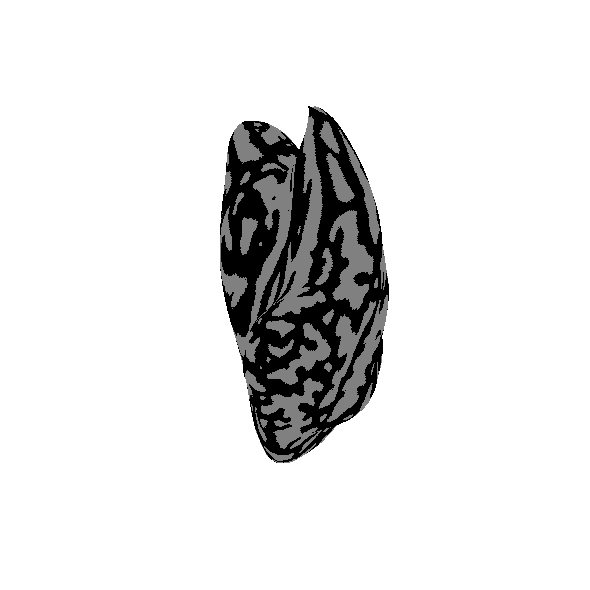

In [17]:
for sub in hbn_subs:
    # get subject data
    # get subject data
    infl = surface.load_surf_mesh(f'{hbn_dir}/{sub}/surf/lh.inflated')
    curv = surface.load_surf_data(f'{hbn_dir}/{sub}/surf/lh.curv')
    
    # make curvature mask
    curv_mask = np.zeros_like(curv)
    curv_mask[curv > 0] = 1.0
    
    # get subject angles
    ds = da[da.Subject == sub]
    angles = [[a1, a2] for a1, a2 in zip(ds['Angle1'], ds['Angle2'])]
    
    # make images, one per view
    for a in angles:
        fig, ax = plt.subplots(figsize=(8, 8))
        plotting.plot_surf_roi(infl, curv_mask
            ,view=a
            # ,bg_on_data=True 
            ,figure=fig
            ,cmap='gray'
            ,threshold=0.0
            ,output_file=f'{out_dir}/{sub}-{a[0]:.2f}-{a[1]:.2f}-curv-mask.png'
            # ,colorbar=True
            )